<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/aae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Состязательный автокодировщик

Есть код вариационного автокодировщика. Заменить KL-дивергенцию на дискриминатор, получив тем самым состязательный автокодировщик. Дискриминатор должен отличать латентное представление на выходе энкодера от семплов из нормального распределения. Можно тоже на MNIST.

# Подготовка окружения

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

## Загрузка данных для обучения

In [3]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11493376/11490434 [==============================] - 0s 0us/step


## Гиперпараметры

In [0]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

## Утилиты

In [0]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

# Создание автокодировщика

In [0]:
class AE:
    def sampling(self, args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.
        # Arguments:
            args (tensor): mean and log of variance of Q(z|X)
        # Returns:
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    def create_encoder(self):
        print("Creating encoder")
        x = Dense(intermediate_dim, activation='relu')(self.inputs)
        self.z_mean = Dense(latent_dim, name='z_mean')(x)
        self.z_log_var = Dense(latent_dim, name='z_log_var')(x)

        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(self.sampling, output_shape=(latent_dim,), name='z')([self.z_mean, self.z_log_var])

        # instantiate encoder model
        encoder = Model(self.inputs, [self.z_mean, self.z_log_var, z], name='encoder')
        encoder.summary()
        
        return encoder
    
    def create_decoder(self):
        print("Creating decoder")
        # build decoder model
        latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
        x = Dense(intermediate_dim, activation='relu')(latent_inputs)
        outputs = Dense(original_dim, activation='sigmoid')(x)

        # instantiate decoder model
        decoder = Model(latent_inputs, outputs, name='decoder')
        decoder.summary()

        return decoder

    def plot_models(self):
        plot_model(self.decoder, to_file='vae_mlp_decoder.png', show_shapes=True)
        plot_model(self.encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
        plot_model(self.vae,
                   to_file='vae_mlp.png',
                   show_shapes=True)
    
    def models(self):
        return (self.encoder, self.decoder)
    
    def __init__(self):
        self.inputs = Input(shape=input_shape, name='encoder_input')
        
        self.encoder = self.create_encoder()
        self.decoder = self.create_decoder()
        
        # instantiate VAE model
        outputs = self.decoder(self.encoder(self.inputs)[2])
        self.vae = Model(self.inputs, outputs, name='vae_mlp')

        # VAE loss = mse_loss or xent_loss + kl_loss
        reconstruction_loss = binary_crossentropy(self.inputs, outputs)
        # reconstruction_loss = mse(self.inputs, outputs)
        reconstruction_loss *= original_dim
        kl_loss = 1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self.vae.add_loss(vae_loss)

        self.vae.compile(optimizer='adam')
        self.vae.summary()

    def train(self):
        self.vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
        



## Обучение автокодировщика

Creating encoder
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_7[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_7[0][0]                    
____________________________________________________________________________________________

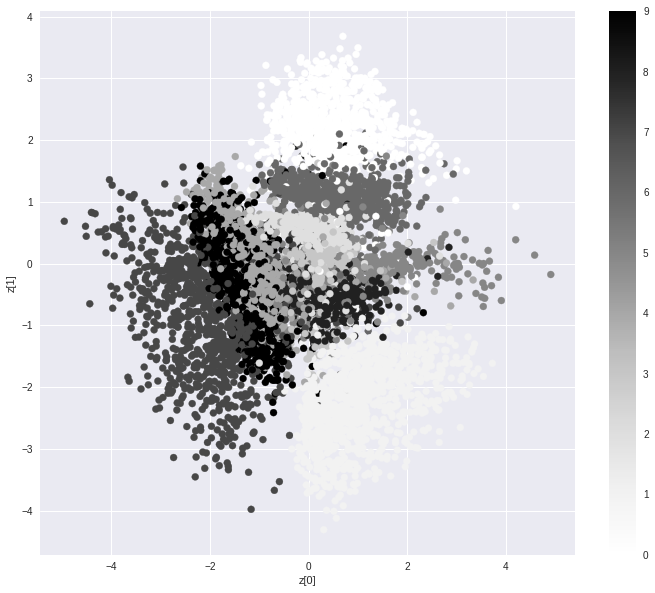

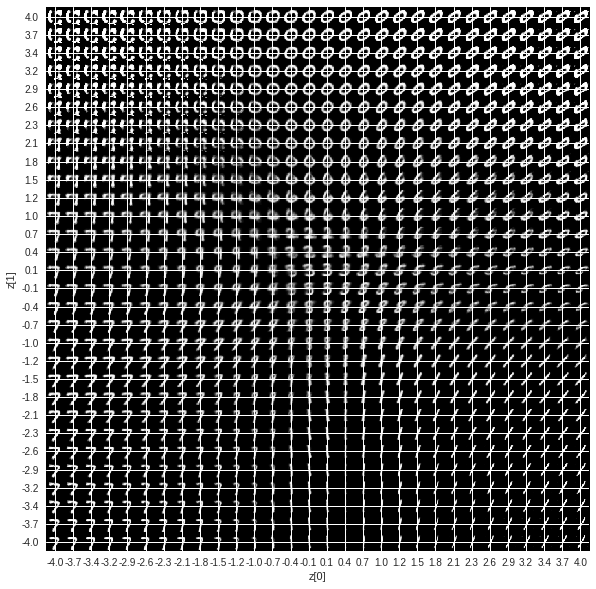

In [16]:
ae = AE()
ae.train()

# vae.save_weights('vae_mlp_mnist.h5')

plot_results(ae.models(),
         (x_test, y_test),
         batch_size=batch_size,
         model_name="vae_mlp")